In [25]:
import numpy as np 
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import matplotlib
from pandas import DataFrame
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 999
import xgboost as xgb
from sklearn.model_selection import KFold
from xgboost import XGBRegressor 
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score

In [2]:
train=pd.read_csv("mertrain.csv")
test=pd.read_csv("mertest.csv")

In [3]:
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder() 
        lbl.fit(list(train[c].values) + list(test[c].values)) 
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))
print('Shape train: {}\nShape test: {}'.format(train.shape, test.shape))

Shape train: (4209, 378)
Shape test: (4209, 377)


In [4]:
vif_best=["X178", "X362", "X331", "X49", "X238", "X215", "X161", "X103",
 "X329", "X328", "X356", "X246","X85", "X45", "X256", "X191", "X352", "X343", "X179",
 "X355","X43","X272","X2","X219","X321" ,"X367" ,"X241" ,"X234" ,"X57" ,"X150" ,"X197"]

In [87]:
y = train['y'].values
y_mean = np.mean(y)
id_test = test['ID'].values
X_vif = train.drop(vif_best, axis=1).drop('y', axis=1).values
X_test_vif= test.drop(vif_best, axis=1).values

In [88]:
kf=KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(X_vif)

5

In [89]:
for train_index, test_index in kf.split(X_vif):
    X_train_vif, y_train_vif=X_vif[train_index], y[train_index]
    X_valid_vif, y_valid_vif=X_vif[test_index], y[test_index]

In [90]:
estimator = XGBRegressor(base_score=100.66931812782134, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=1.0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=2,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=1.0,
       reg_lambda=1.0, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.8)

In [91]:
estimator.fit(X_train_vif, y_train_vif)

XGBRegressor(base_score=100.66931812782134, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=1.0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=2,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=1.0,
       reg_lambda=1.0, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.8)

In [51]:
X= train.drop(['y'], axis=1).values
X_test= test.values

In [52]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(X)

5

In [53]:
for train_index, test_index in kf.split(X):
    X_train, y_train=X[train_index], y[train_index]
    X_valid, y_valid=X[test_index], y[test_index]

In [18]:
estimator = XGBRegressor(base_score=100.66931812782134, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=1.0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=2,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=1.0,
       reg_lambda=1.0, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.8)

In [20]:
selector = RFECV(estimator, step=5, cv=5, n_jobs=2)

In [21]:
selector.fit(X_train, y_train)

RFECV(cv=5,
   estimator=XGBRegressor(base_score=100.66931812782134, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=1.0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=2,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=1.0,
       reg_lambda=1.0, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.8),
   n_jobs=2, scoring=None, step=5, verbose=0)

In [69]:
print("R^2 valid: {: }".format(r2_score(y_valid, selector.predict(X_valid))))
print("R^2 train: {: }".format(r2_score(y_train, selector.predict(X_train))))

R^2 valid:  0.5932869296551689
R^2 train:  0.6038073891312494


In [92]:
y_pred_RFE=selector.predict(X_test)
y_pred_vif=estimator.predict(X_test_vif)

In [93]:
pist_valid=[]
pist_train=[]
for i in np.arange(0,1, 0.05):
    y_pre_pred=(estimator.predict(X_valid_vif)*i )+ (selector.predict(X_valid)*(1.0-i))
    y_train_pred=(estimator.predict(X_train_vif)*i)+( selector.predict(X_train)*(1.0-i))
    r2_valid=r2_score(y_valid, y_pre_pred)
    r2_train=r2_score(y_train, y_train_pred)
    pist_valid.append(r2_valid)
    pist_train.append(r2_train)

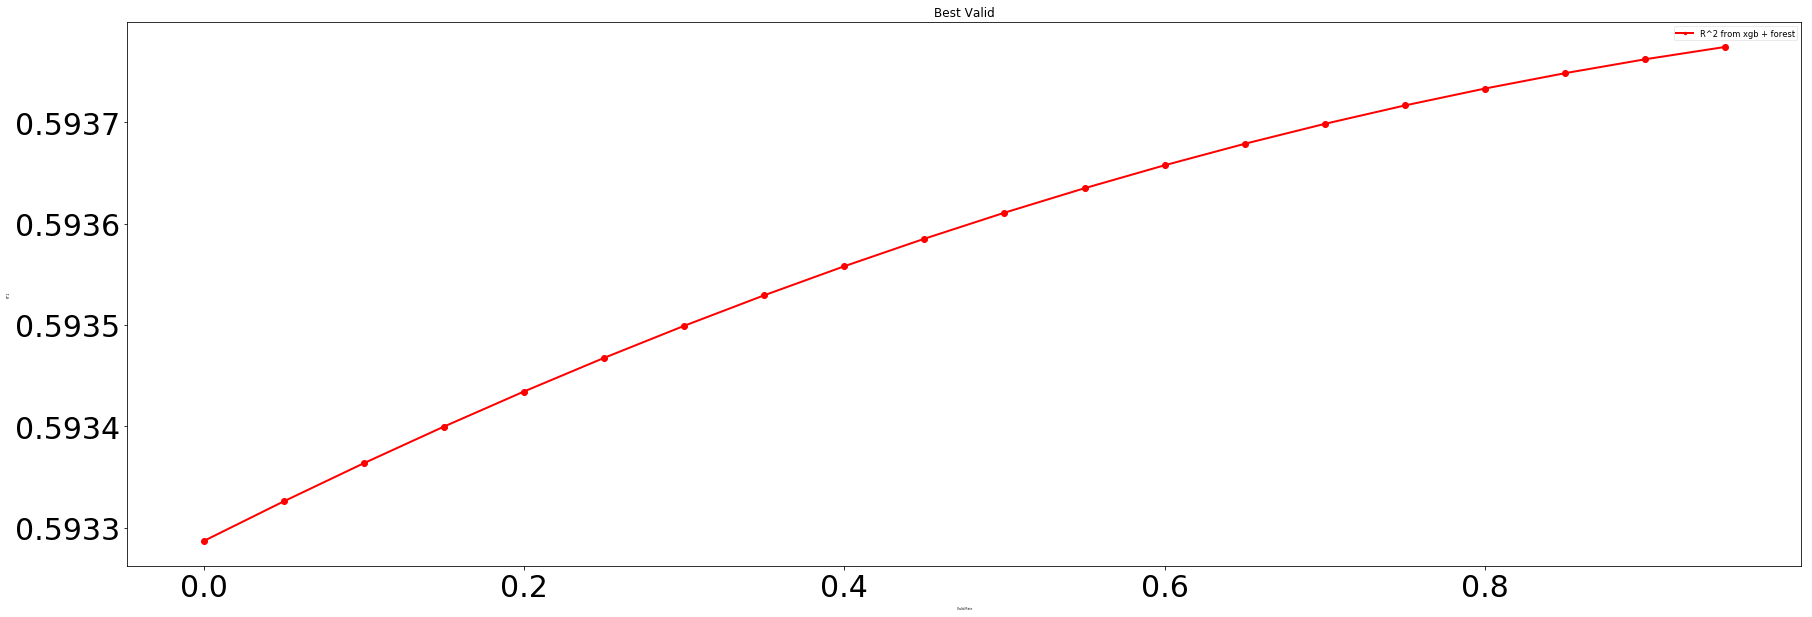

In [94]:
ig = plt.figure(figsize=(30,10))
plt.plot(np.arange(0,1,0.05), pist_valid, 'ro-', linewidth=2)
plt.title('Best Valid')
plt.xlabel('Valid Rate',fontsize=3)
plt.ylabel('R^2',fontsize=3)
plt.tick_params(labelsize=30)
leg = plt.legend(['R^2 from xgb + forest'], loc='best', borderpad=0.3,
                 shadow=False, prop= matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.draggable(state=True)
plt.show()

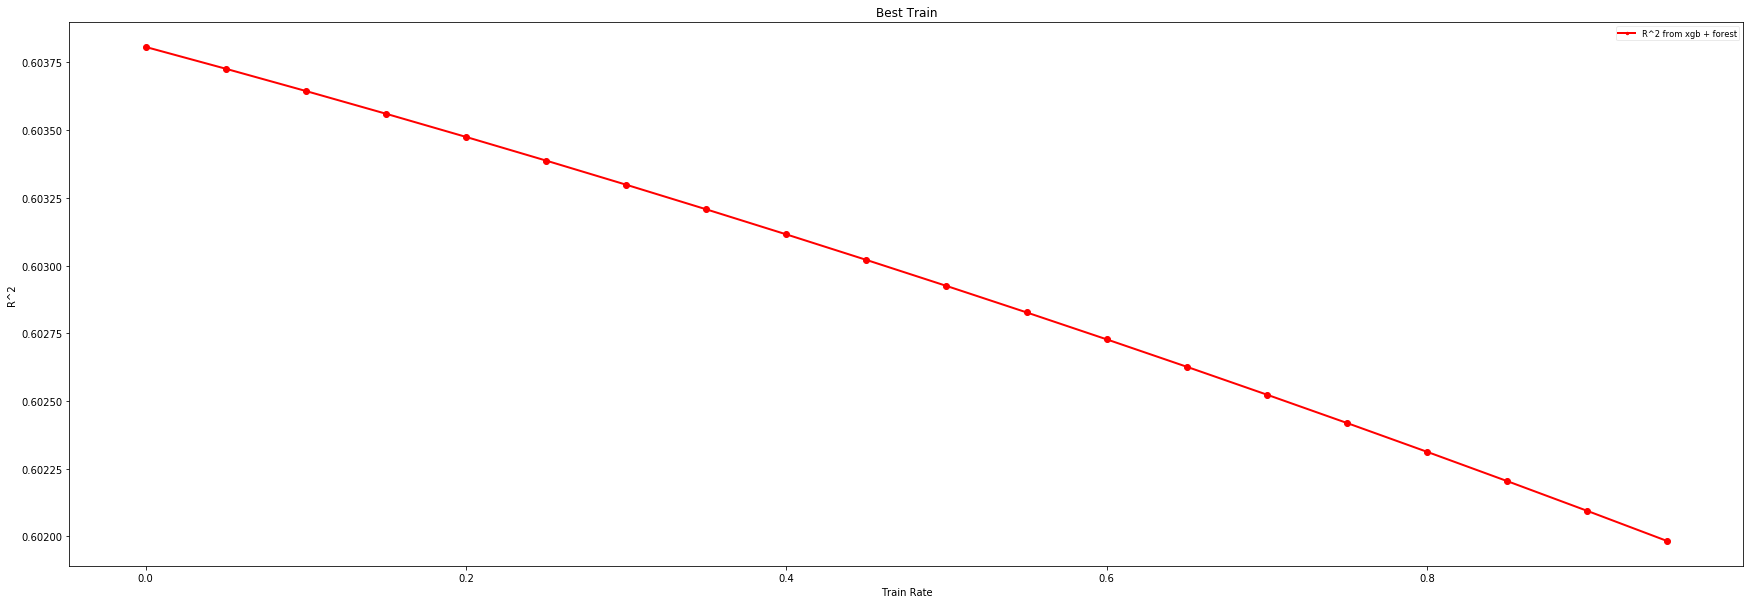

In [95]:
ig = plt.figure(figsize=(30,10))
plt.plot(np.arange(0,1,0.05), pist_train, 'ro-', linewidth=2)
plt.title('Best Train')
plt.xlabel('Train Rate')
plt.ylabel('R^2')
leg = plt.legend(['R^2 from xgb + forest'], loc='best', borderpad=0.3,
                 shadow=False, prop= matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.draggable(state=True)
plt.show()